# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/acoullandreau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/acoullandreau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/acoullandreau/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
# import libraries

#note that sklearn's version should be at least 0.20.0

#import for NLP
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

#import for object manipulation
import numpy as np
import pandas as pd
import re
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

#import for ML pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql("SELECT * FROM MessagesWithCategory", engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#we define X as the first 4 columns (we will filter out the 'messages' column afterwards) and the other
#36 category columns as Y
X = df.iloc[:, :4]
Y = df.iloc[:, 5:]

### 2. Write a tokenization function to process your text data

In [5]:
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    #we convert the text to lower case
    text = text.lower()
    
    #we remove any url contained in the text
    
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    url_in_msg = re.findall(url_regex, text)
    for url in url_in_msg:
        text = text.replace(url, "urlplaceholder")
        
    # we remove the punctuation
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    
    # we tokenize the text
    words = word_tokenize(text)
    
    # we lemmatize  and remove the stop words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    
    return words

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [6]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)))
])


Notes on the choices:
- The classifier used is Random Forest with its default parameters. This is the classifier chosen for 3 reasons:
    - there are many "features" (i.e words in our case) to consider, and the model will focus on the important variables for the classification
    - the dataset we are looking at is not too big, so no risk to have it take too long to process or be too demanding with memory
    - the execution of the model can be parallelize, which makes it faster to execute!
- CountVectorizer is instantiated using the tokenize() function defined previously - first the input is tokenized then vectorized
- Associated to this vectorisation step, we apply TF-IDF on the matrix obtained as to take into account the frequency of each word in all messages. This allows to weigh each word relatively to how often it appears in all messages, thus understanding the importance of each word for the assignment to the categories labelling a message.


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [95]:
#we split the column 'message' of X and the whole Y dataframe into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X['message'], Y, test_size=0.2, random_state=42)

#we fit the pipeline using the training sets
pipeline.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                  

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [9]:
#we predict the categories using the testing set
y_pred = pipeline.predict(X_test)

In [10]:
overall_accuracy_default = (y_pred == y_test).mean().mean()

print('Average default config overall accuracy {0:.2f}% \n'.format(overall_accuracy_default*100))

Average default config overall accuracy 94.94% 



In [11]:
#### we define a function to build the classification report on each category of Y
def compute_metrics(y_test, y_pred):
    i=0
    reports = {}
    for column in y_test.columns:
        report = classification_report(y_test[column], y_pred[:,i], labels=np.unique(y_pred[:,i]), output_dict=True)
        reports[column]=report['weighted avg']
        #reports[column]['category'] = column
        reports[column]['accuracy'] = (y_pred[:,i] == y_test[column]).mean()
        i+=1
    
    return reports

def create_df_from_dict(results, scenario):
    df = pd.DataFrame.from_dict(results, orient='index')
    df.drop('support', axis=1, inplace=True)
    df.rename(columns={"precision": 'Precision_{}'.format(scenario),
                       "recall": 'Recall_{}'.format(scenario),
                       "f1-score":'F1_score_{}'.format(scenario),
                       "accuracy":'Accuracy_{}'.format(scenario)}, inplace=True)
    return df

#we define another function to build a dataframe with the scores in order to be able to compare the results
#of different scenarios
def append_results_to_df(df, results, scenario):

    if df.empty:
        df = create_df_from_dict(results, scenario)

    else:
        df_2 = create_df_from_dict(results, scenario)
        df = pd.concat([df, df_2], axis=1)

    return df

results = compute_metrics(y_test, y_pred)
df_results = pd.DataFrame()
df_results = append_results_to_df(df_results, results, 'default_config')
df_results

,Precision_default_config,Recall_default_config,F1_score_default_config,Accuracy_default_config
request,0.874280,0.882723,0.868475,0.882723
offer,0.995042,1.000000,0.997515,0.995042
aid_related,0.756165,0.757437,0.752473,0.757437
medical_help,0.903899,0.922960,0.895423,0.922960
medical_products,0.944951,0.951945,0.933289,0.951945
search_and_rescue,0.971251,0.976926,0.967806,0.976926
security,0.966704,0.982265,0.974422,0.982265
military,0.964578,0.971968,0.961617,0.971968
child_alone,1.000000,1.000000,1.000000,1.000000
water,0.948428,0.953280,0.944304,0.953280


A few comments at this point:
- all metrics are homogeneous for each category (i.e they are centered more or less around the same value for each category individually)
- the overall average accuracy of this default model is 94.94%
- accuracy and recall have the same values for most categories, we will therefore look at only one of the two metrics
- it seems like F1 is the lowest score for almost all categories, so let's take a closer look at this metric to evaluate our model

In [12]:
df_results.sort_values('F1_score_default_config')

,Precision_default_config,Recall_default_config,F1_score_default_config,Accuracy_default_config
aid_related,0.756165,0.757437,0.752473,0.757437
other_aid,0.829584,0.868612,0.817645,0.868612
direct_report,0.833471,0.846491,0.822070,0.846491
weather_related,0.855572,0.858505,0.851387,0.858505
request,0.874280,0.882723,0.868475,0.882723
medical_help,0.903899,0.922960,0.895423,0.922960
infrastructure_related,0.907231,0.937262,0.908554,0.937262
shelter,0.920518,0.927918,0.910315,0.927918
other_weather,0.924795,0.947368,0.923927,0.947368
storm,0.927409,0.934783,0.927303,0.934783


Main conclusions on the evaluation of this first model:

- in general, the scores are between 0.75 and 1
- the lowest scores are obtained for the following categories:
    - aid_related
    - other_aid
    - direct_report
    - weather_related
    - request
- the highest scores are obtained for the following categories:
    - aid_centers
    - missing_people
    - hospitals
    - tools
    - offer
    - shops
    - child_alone

Let's try to understand why those highest scores are obtained. Let's see if we have unbalanced classes.

In [21]:
#first let's define another dataset with the percentage of 0 and 1 for each category

df_source = df.drop(['id', 'message', 'original', 'genre'], axis=1)
counts = []
categories = list(df_source.columns.values)
for i in categories:
    messages_tagged_1 = df_source[i].sum()
    messages_tagged_1 = messages_tagged_1*100/df_source.shape[0]
    messages_tagged_0 = df_source.shape[0]-df_source[i].sum()
    messages_tagged_0 = messages_tagged_0*100/df_source.shape[0]
    counts.append((i, messages_tagged_1, messages_tagged_0))
df_stats = pd.DataFrame(counts, columns=['Disaster message category', 'Distribution ratio - 1', 'Distribution ratio - 0'])
df_stats.sort_values(by=['Distribution ratio - 1'], inplace=True)
df_stats

,Disaster message category,Distribution ratio - 1,Distribution ratio - 0
9,child_alone,0.000000,100.000000
2,offer,0.450107,99.549893
25,shops,0.457736,99.542264
23,tools,0.606500,99.393500
31,fire,1.075679,98.924321
24,hospitals,1.079493,98.920507
15,missing_people,1.136710,98.863290
26,aid_centers,1.178670,98.821330
13,clothing,1.544858,98.455142
7,security,1.796613,98.203387


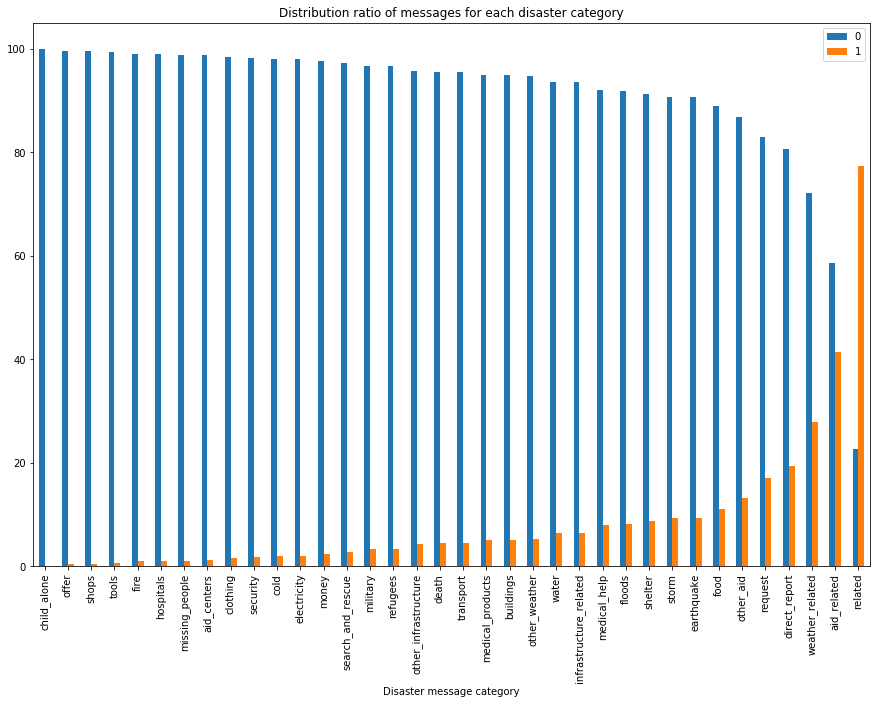

In [22]:
#let's plot this dataset and observe the distributions

x = df_stats['Disaster message category']
y = df_stats['Distribution ratio - 0']
z = df_stats['Distribution ratio - 1']

df_plot = pd.DataFrame(np.c_[y,z], index=x)
df_plot.plot.bar(figsize=(15, 10), title='Distribution ratio of messages for each disaster category')

plt.show();

It seems obvious that the dataset has unbalanced classes ! And we can see that the classes that had the lowest accuracy scores are those with a better distribution of values than those that had the highest accuracy scores ! We should therefore be careful in our interpretation of those high results, and focus on increasing the overall accuracy of the categories with the lowest score. 

Further on when we compare the scores between models, we should look at the categories that performed "worse", those classes with a more balanced distribution of values.

Let's see what kind of improvement we can achieve using Gridsearch.

### 6. Improve your model
Use grid search to find better parameters. 

In [15]:
#Let's first take a look at the current parameters set for the pipeline
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x1a24c30e18>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_depth=None,
                                                          max_features='auto',
           

In [18]:
#let's set a list of parameters that have an influence on all estimators

parameters = {
    'vect__ngram_range':[(1, 1), (1, 2)],
    'vect__max_df':[0.5, 0.75, 1],
    'clf__estimator__n_estimators':[10, 100, 250]
}
            
cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, cv=3) 
#we specify cv=3, i.e the cross-validation splitting strategy - 3 folds 

#let's repeat the fit and predict steps but now trying with all combinations of parameters set above
cv.fit(X_train, y_train)
y_pred_optim = cv.predict(X_test)


/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [19]:
print(cv.best_params_)

{'clf__estimator__n_estimators': 250, 'vect__max_df': 1, 'vect__ngram_range': (1, 2)}


Note that we initially tried with a lot more parameters, but due to processing power limitations, we limited the number of combinations to the most relevant ones to try to balance the time required to obtain a result.

It seems like the optimal combination of parameters differs from the default set on:
- vect__ngram_range = (1, 2)
- clf__estimator__n_estimators = 250

vect__max_df and is better set as the initial default values (1).

In [23]:
overall_accuracy_default = (y_pred == y_test).mean().mean()
overall_accuracy_GS = (y_pred_optim == y_test).mean().mean()

print('Average default config overall accuracy {0:.2f}% \n'.format(overall_accuracy_default*100))
print('Average gridsearch overall accuracy {0:.2f}% \n'.format(overall_accuracy_GS*100))

Average default config overall accuracy 94.94% 

Average gridsearch overall accuracy 93.28% 



### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [24]:
#we simply run the function defined above with the new y_pred
results_grid_search = compute_metrics(y_test, y_pred_optim)
df_results = append_results_to_df(df_results, results_grid_search, 'grid_search')
df_results

,Precision_default_config,Recall_default_config,F1_score_default_config,Accuracy_default_config,Precision_grid_search,Recall_grid_search,F1_score_grid_search,Accuracy_grid_search
request,0.874280,0.882723,0.868475,0.882723,0.816125,0.833715,0.766891,0.833715
offer,0.995042,1.000000,0.997515,0.995042,0.995042,1.000000,0.997515,0.995042
aid_related,0.756165,0.757437,0.752473,0.757437,0.649787,0.612319,0.501846,0.612319
medical_help,0.903899,0.922960,0.895423,0.922960,0.889643,0.919718,0.883958,0.919718
medical_products,0.944951,0.951945,0.933289,0.951945,0.934669,0.948894,0.925113,0.948894
search_and_rescue,0.971251,0.976926,0.967806,0.976926,0.952137,0.975210,0.963535,0.975210
security,0.966704,0.982265,0.974422,0.982265,0.970248,0.982647,0.974972,0.982647
military,0.964578,0.971968,0.961617,0.971968,0.951780,0.970252,0.956161,0.970252
child_alone,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
water,0.948428,0.953280,0.944304,0.953280,0.908614,0.935355,0.907316,0.935355


We can observe that with the optimal set of parameters found ealier with GridSearch, we actually have an overall accuray that is lower than with the default set of values! 
This should not be the case, we should at worse get the exact same overall accuracy, but not lower...
Can we do better?

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

There are a few options we can try:
- use another machine learning model, such as SVM, or a Naive Bayes model instead of Random Forest
- perform other transformations on the data
- use word embedding instead of TF-IDF (for example GloVe), to evaluate a word in its context and not alone

We are going to try with the first option with two new models, using the default hyperparmaters sklearn implements.
We are going to compare these results with the initial default_config.

In [25]:
# we define a new pipeline with the new estimators
from sklearn.naive_bayes import MultinomialNB

pipeline_alt_MNB = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(MultinomialNB(), n_jobs=1))
])


In [26]:
#we fit the pipeline_alt using the training sets
pipeline_alt_MNB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x1a24c30e18>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=MultinomialNB(alpha=1.0,
               

In [27]:
#we predict the categories using the testing set
y_pred_alt_MNB = pipeline_alt_MNB.predict(X_test)

In [28]:
#let's see how the metrics changed with MNB
results_alt_MNB = compute_metrics(y_test, y_pred_alt_MNB)
df_results = append_results_to_df(df_results, results_alt_MNB, 'MNB')
df_results

,Precision_default_config,Recall_default_config,F1_score_default_config,Accuracy_default_config,Precision_grid_search,Recall_grid_search,F1_score_grid_search,Accuracy_grid_search,Precision_MNB,Recall_MNB,F1_score_MNB,Accuracy_MNB
request,0.874280,0.882723,0.868475,0.882723,0.816125,0.833715,0.766891,0.833715,0.860375,0.861747,0.826873,0.861747
offer,0.995042,1.000000,0.997515,0.995042,0.995042,1.000000,0.997515,0.995042,0.995042,1.000000,0.997515,0.995042
aid_related,0.756165,0.757437,0.752473,0.757437,0.649787,0.612319,0.501846,0.612319,0.755960,0.758009,0.754605,0.758009
medical_help,0.903899,0.922960,0.895423,0.922960,0.889643,0.919718,0.883958,0.919718,0.919527,1.000000,0.958077,0.919527
medical_products,0.944951,0.951945,0.933289,0.951945,0.934669,0.948894,0.925113,0.948894,0.899667,0.948322,0.923354,0.948322
search_and_rescue,0.971251,0.976926,0.967806,0.976926,0.952137,0.975210,0.963535,0.975210,0.975782,1.000000,0.987742,0.975782
security,0.966704,0.982265,0.974422,0.982265,0.970248,0.982647,0.974972,0.982647,0.983219,1.000000,0.991538,0.983219
military,0.964578,0.971968,0.961617,0.971968,0.951780,0.970252,0.956161,0.970252,0.970442,1.000000,0.985000,0.970442
child_alone,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
water,0.948428,0.953280,0.944304,0.953280,0.908614,0.935355,0.907316,0.935355,0.874877,0.935164,0.904016,0.935164


Conclusion, using MNB, the overall scores are lower, so let's explore another option.

In [29]:
from sklearn.ensemble import AdaBoostClassifier

pipeline_alt_ADA = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)))
])

In [30]:
#we fit the pipeline_alt using the training sets
pipeline_alt_ADA.fit(X_train, y_train)

#we predict the categories using the testing set
y_pred_alt_ADA = pipeline_alt_ADA.predict(X_test)

In [31]:
#let's see how the metrics changed
results_alt_ADA = compute_metrics(y_test, y_pred_alt_ADA)
df_results = append_results_to_df(df_results, results_alt_ADA, 'alternative_ADA')
df_results

,Precision_default_config,Recall_default_config,F1_score_default_config,Accuracy_default_config,Precision_grid_search,Recall_grid_search,F1_score_grid_search,Accuracy_grid_search,Precision_MNB,Recall_MNB,F1_score_MNB,Accuracy_MNB,Precision_alternative_ADA,Recall_alternative_ADA,F1_score_alternative_ADA,Accuracy_alternative_ADA
request,0.874280,0.882723,0.868475,0.882723,0.816125,0.833715,0.766891,0.833715,0.860375,0.861747,0.826873,0.861747,0.873278,0.876430,0.853351,0.876430
offer,0.995042,1.000000,0.997515,0.995042,0.995042,1.000000,0.997515,0.995042,0.995042,1.000000,0.997515,0.995042,0.995042,1.000000,0.997515,0.995042
aid_related,0.756165,0.757437,0.752473,0.757437,0.649787,0.612319,0.501846,0.612319,0.755960,0.758009,0.754605,0.758009,0.737350,0.727307,0.709653,0.727307
medical_help,0.903899,0.922960,0.895423,0.922960,0.889643,0.919718,0.883958,0.919718,0.919527,1.000000,0.958077,0.919527,0.896529,0.921053,0.891698,0.921053
medical_products,0.944951,0.951945,0.933289,0.951945,0.934669,0.948894,0.925113,0.948894,0.899667,0.948322,0.923354,0.948322,0.948711,0.954233,0.938516,0.954233
search_and_rescue,0.971251,0.976926,0.967806,0.976926,0.952137,0.975210,0.963535,0.975210,0.975782,1.000000,0.987742,0.975782,0.976348,0.977689,0.968583,0.977689
security,0.966704,0.982265,0.974422,0.982265,0.970248,0.982647,0.974972,0.982647,0.983219,1.000000,0.991538,0.983219,0.983219,1.000000,0.991538,0.983219
military,0.964578,0.971968,0.961617,0.971968,0.951780,0.970252,0.956161,0.970252,0.970442,1.000000,0.985000,0.970442,0.957327,0.970252,0.958822,0.970252
child_alone,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
water,0.948428,0.953280,0.944304,0.953280,0.908614,0.935355,0.907316,0.935355,0.874877,0.935164,0.904016,0.935164,0.959829,0.963005,0.960063,0.963005


In [32]:
overall_accuracy_default = (y_pred == y_test).mean().mean()
overall_accuracy_GS = (y_pred_optim == y_test).mean().mean()
overall_accuracy_MNB = (y_pred_alt_MNB == y_test).mean().mean()
overall_accuracy_ADA = (y_pred_alt_ADA == y_test).mean().mean()

print('Average default config overall accuracy {0:.2f}% \n'.format(overall_accuracy_default*100))
print('Average grid search config overall accuracy {0:.2f}% \n'.format(overall_accuracy_GS*100))
print('Average alternative MNB overall accuracy {0:.2f}% \n'.format(overall_accuracy_MNB*100))
print('Average alternative ADA overall accuracy {0:.2f}% \n'.format(overall_accuracy_ADA*100))


Average default config overall accuracy 94.94% 

Average grid search config overall accuracy 93.28% 

Average alternative MNB overall accuracy 94.13% 

Average alternative ADA overall accuracy 94.95% 



**Results of the model tuning**

It appears that the best combination of model and hyperparameters is the following:
- AdaBoost with n_estimators=100 and learning_rate=0.1
- CountVectorizer with the default hyperparameters


Now let's see if we add some processing on the messages in parallel of the current vectorization and TF-IDF applications. 
We are going to define two new transformers:
- average word length computation: the idea is to compute the average word length for each message
- number of words: the idea is to compute the total number of words in each message
- number of non stop words: the idea is to compute the total number of words in each message that is not a stop word (in English)
- word popularity score: likewise, the popularity of each word based on the category could bring an additional insight on the correlation between vocabulary and labeling. Note that this approach is somewhat similar to TF-IDF to the exception that we do not want to look only at the frequency of a word with regard to all the documents (messages), but its popularity with regard to a particular category. 

Clearly, we are trying to engineer new features to help us predict the label of a given message.

In [34]:
class AverageWordLength(BaseEstimator, TransformerMixin):

    def word_length(self, text):
        words = text.split()
        if len(words)>0:
            avg_length = sum(len(word) for word in words)/len(words)
            return avg_length
        return 0
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_avg_length = pd.Series(X).apply(self.word_length)
        return pd.DataFrame(X_avg_length)

In [37]:
class NumWords(BaseEstimator, TransformerMixin):

    def count_word(self, text):
        words = text.split()
        return len(words)
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_num_words = pd.Series(X).apply(self.count_word)
        return pd.DataFrame(X_num_words)


class NumStopWords(BaseEstimator, TransformerMixin):

    def count_stop_word(self, text):
        words = text.split()
        c=0
        for word in words:
            if words in stopwords.words('english'):
                c+=1
        return c
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_num_stop_words = pd.Series(X).apply(self.count_stop_word)
        return pd.DataFrame(X_num_stop_words)
    

In [39]:
#We define a function that maps each word to the categories associated to all messages they appear in

cat_idx = {0: 'related', 1: 'request', 2: 'offer', 3: 'aid_related', 4: 'medical_help',
           5: 'medical_products', 6: 'search_and_rescue', 7: 'security', 8: 'military',
           9: 'child_alone', 10: 'water', 11: 'food', 12: 'shelter', 13: 'clothing',
           14: 'money', 15: 'missing_people', 16: 'refugees', 17: 'death', 18: 'other_aid',
           19: 'infrastructure_related', 20: 'transport', 21: 'buildings', 22: 'electricity',
           23: 'tools', 24: 'hospitals', 25: 'shops', 26: 'aid_centers', 27: 'other_infrastructure',
           28:'weather_related', 29: 'floods', 30: 'storm', 31: 'fire', 32: 'earthquake', 33: 'cold',
           34: 'other_weather', 35: 'direct_report'}

def word_count_per_cat(df):
    df_cat = df.drop(['id', 'original', 'genre'], axis=1)
    word_cat_dict = {}
    for row in range(len(df)): 
        message = df.iloc[row, 1]
        list_of_cat = []
        for k in range(0, df.shape[1]-4):
            if df.iloc[row, k]==1:
                list_of_cat.append(cat_idx[k])
        words = tokenize(message)
        
        if list_of_cat != []:  
            for word in words:
                if word not in word_cat_dict:
                    word_cat_dict[word]={}

                for cat in list_of_cat:
                    if cat not in word_cat_dict[word]:
                        word_cat_dict[word][cat]=1
                    else:
                        word_cat_dict[word][cat]+=1
    return word_cat_dict
    
word_cat_dict = word_count_per_cat(df)

In [89]:
class PopPerCat(BaseEstimator, TransformerMixin):
    
    def __init__(self, word_dict):
        self.word_cat_dict = word_dict
    
    def count_word_per_cat(self, text, word_cat_dict):
        words = text.split()
        count_per_cat = {}
        for word in words:
            if word in word_cat_dict:
                for cat in word_cat_dict[word]:
                    if cat not in count_per_cat:
                        count_per_cat[cat]=1
                    else:
                        count_per_cat[cat]+=1
        return count_per_cat
      
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_count_cat = pd.DataFrame()
        for x in X:
            x_count = self.count_word_per_cat(x, self.word_cat_dict)
            X_count_cat = X_count_cat.append(x_count, ignore_index=True)
        X_count_cat.fillna(0, inplace=True)
        return X_count_cat

This last class highlights the number of words for each message frequently used in each category.

For example, if we look at the first two messages in X_train, we see that 12 words of the first message and 6 words of the second message actually appear in aid_centers classified messages. But only 5 words of those two messages appear in search_and_rescue classified messages.

In [97]:
PopPerCat_instance = PopPerCat(word_cat_dict)
X_lim = X_train.iloc[:2]
df_PopPerCat = PopPerCat_instance.transform(X_lim)
df_PopPerCat

,aid_centers,buildings,child_alone,cold,death,direct_report,earthquake,electricity,fire,floods,...,refugees,search_and_rescue,security,shelter,shops,storm,tools,transport,water,weather_related
0,12.0,15.0,14.0,14.0,11.0,11.0,14.0,14.0,14.0,9.0,...,13.0,5.0,16.0,16.0,14.0,12.0,14.0,13.0,11.0,9.0
1,6.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,7.0,4.0,...,6.0,5.0,7.0,6.0,6.0,6.0,7.0,7.0,6.0,6.0


In [101]:
pipeline_comb = Pipeline([
    ('features', FeatureUnion([
        ('input_text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer()),
        ])),
        ('feat_eng_length', Pipeline([
            ('average_length', AverageWordLength()),
        ])), 
        ('feat_eng_count', Pipeline([
            ('word_count', NumWords()),
        ])), 
        ('feat_eng_stop_count', Pipeline([
            ('stop_word_count', NumStopWords()),
        ])),
        ('feat_eng_pop', Pipeline([
            ('word_count_per_cat', PopPerCat(word_dict=word_cat_dict)),
        ])),   
    ])),
        
    ('clf', MultiOutputClassifier(AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)))
])

In [98]:
#fit the new pipeline
pipeline_comb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('input_text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                               

In [99]:
#predict the labels using the pipeline
y_pred_comb = pipeline_comb.predict(X_test)

In [100]:
overall_accuracy_comb = (y_pred_comb == y_test).mean().mean()
print('Average overall accuracy {0:.2f}% \n'.format(overall_accuracy_comb*100))

Average overall accuracy 95.00% 



Now let's see if with GridSearch we manage to increase a little this accuracy ?

**Conclusions of the model tuning work**

As a final conclusion, the model we are going 

We could, of course, run GridSearch again on 

### 9. Export your model as a pickle file

In [ ]:
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [ ]:
# save the model to disk
import pickle
filename = 'trained_model_save.sav'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.